# Localization 

*Project Members*


| Name       | Marticulation Number     | Contribution |
|--------------|-----------|------------|
| Jenish Thapa | k12137169    | ICP implementation, evaluate and analysis       |
| Christoph Domberger      | k51849497   | ICP implementation, evaluate and analysis      |
| Sebastian Ukleja     | k0512011   | NDT implementation, evaluate and analysis      |
| Prasil Adhikari      | k12049801   | NDT implementation, evaluate and analysis     |


## Project Overview ##

The project objective is to achieve the localization for a car driving within a simulated environment, covering a minimum distance of 170m from its starting position, while keeping the distance pose error within 1.2m. To accomplish this, we will make use of pointclouds extracted from a simulated car equipped with a lidar, which provides regular lidar scans. Additionally, there is an existing point cloud map "map.pcd" available, extracted from the CARLA simulator. We can achieve localization for the car by using point registration algorithms ICP and NDT matching between the map and the scans. We will then evaluate the disatnce pose error between the pose we get from localization algorithm and from the ground truth provided along with the dataset

## Set up ##

You can set up and run this notebook by extracting the files from the zip file and later setting up the docker using the docker file in VS code. Do setup and use xlauncher to get visualization if needed



In this implementation the poincloud library (https://pointclouds.org/) was used, with python bindings from (https://github.com/hummat/registration).
The bindings were slightly adopted for our use case and the pcl110 registration library was used.


In [1]:

#import libraries and frameworks
from typing import Tuple, List

import numpy as np
import open3d as o3d
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import exercises.tools.utils as utils
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from IPython.display import display, Math, Latex, Markdown, HTML

from tqdm import tqdm
import time
import pandas as pd

%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#lib wrapper for cpp registration libary slightly altered from: https://github.com/hummat/registration
#using registration library pcl110

import os
import ctypes
import csv

import numpy as np


def load_library(path: str = os.getcwd(), name: str = "libregistration_pcl110") -> None:
    global REGLIB
    try:
        REGLIB = np.ctypeslib.load_library(libname=name, loader_path=path)
        print("REGLIB loaded")
        print(REGLIB)
    except OSError:
        print("Compiled C++ library was not found in the current directory. Please use `load_library` to load it from "
              "a custom directory, then ignore this message.")


load_library()


def load_data(path: str, delimiter: str = ' ') -> np.ndarray:
    """Loads point cloud data of type `CSV`, `PLY` and `PCD`.

    The file should contain one point per line where each number is separated by the `delimiter` character.
    Any none numeric lines will be skipped.

    Args:
        path (str): The path to the file.
        delimiter (char): Separation of numbers in each line of the file.

    Returns:
        A ndarray of shape NxD where `N` are the number of points in the point cloud and `D` their dimension.
    """
    data = list()
    with open(path, newline='\n') as file:
        reader = csv.reader(file, delimiter=delimiter, quoting=csv.QUOTE_NONNUMERIC)
        lines = 0
        skips = 0
        while True:
            try:
                row = next(reader)
                row = [x for x in row if not isinstance(x, str)]
                if len(row) in [3, 6, 9]:
                    data.append(row[:3])
                else:
                    skips += 1
            except ValueError:
                skips += 1
                pass
            except StopIteration:
                print(f"Found {lines} lines. Skipped {skips}. Loaded {lines - skips} points.")
                break
            lines += 1
    return np.array(data)


def set_argtypes(algorithm, source, target):
    """Tells the underlying C++ code which data types and dimensions to expect.

    Args:
        algorithm (str): The registration algorithm to use. One of `icp` or `ndt`.
        source (ndarray): The source point cloud.
        target (ndarray): The target point cloud.
    """
    REGLIB.icp.restype = ctypes.c_double
    REGLIB.ndt.restype = ctypes.c_double
    argtypes = [np.ctypeslib.ndpointer(dtype=np.float64, ndim=source.ndim, shape=source.shape,
                                       flags='C_CONTIGUOUS'), ctypes.c_size_t,
                np.ctypeslib.ndpointer(dtype=np.float64, ndim=target.ndim, shape=target.shape,
                                       flags='C_CONTIGUOUS'), ctypes.c_size_t,
                np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, shape=(4, 4), flags='C_CONTIGUOUS'),
                ctypes.c_int, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_bool]
    if algorithm == 'icp':
        REGLIB.icp.argtypes = argtypes
    elif algorithm == 'ndt':
        argtypes.extend([ctypes.c_float, ctypes.c_double, ctypes.c_float])
        REGLIB.ndt.argtypes = argtypes


def icp(source,
        target,
        transformation,
        nr_iterations=25,
        distance_threshold=1.0,
        epsilon=1e-6,
        inlier_threshold=0.0005,
        downsample=0,
        visualize=False):
    """The `Iterative Closest Point` (ICP) algorithm.

    Args:
        source (ndarray): The point cloud that we want to align to the target.
        target (ndarray): The point cloud that the source is aligned to.
        nr_iterations (int): The maximum number of iterations the internal optimization should run for.
        distance_threshold (float): The maximum distance threshold between two correspondent points in
                                    source -> target. If the distance is larger than this threshold, the points will
                                    be ignored in the alignment process.
        epsilon (float): The transformation epsilon (maximum allowable difference between two consecutive
                 transformations) in order for an optimization to be considered as having converged to the final
                 solution.
        inlier_threshold (float): The inlier distance threshold for the internal RANSAC outlier rejection loop.
                          The method considers a point to be an inlier, if the distance between the target data
                          index and the transformed source index is smaller than the given inlier distance
                          threshold.
        downsample (float): Assembles a local 3D grid over a given PointCloud and downsamples + filters the data.
        visualize (bool): Can be used to visualize and control the progress of the algorithm.

    Returns:
        A ndarray with the final transformation matrix between source and target.
    """

 
    
    set_argtypes('icp', source, target)
    score = REGLIB.icp(source, len(source), target, len(target), transformation,
                       nr_iterations, distance_threshold, epsilon, inlier_threshold, downsample, visualize)
    print(f"ICP converged. Fitness score: {score:.2f}") if score > 0 else print("ICP did not converge!")
    return transformation


def ndt(source,
        target,
        nr_iterations=25,
        distance_threshold=1.0,
        epsilon=0.01,
        inlier_threshold=0.05,
        downsample=0,
        visualize=False,
        resolution=1.0,
        step_size=0.1,
        voxelize=0,
        transformation=np.identity(4)):
    """The `Normal Distributions Transform` (NDT) algorithm.

    Args:
        source (ndarray): The point cloud that we want to align to the target.
        target (ndarray): The point cloud that the source is aligned to.
        nr_iterations (int): The maximum number of iterations the internal optimization should run for.
        distance_threshold (float): The maximum distance threshold between two correspondent points in
                                    source -> target. If the distance is larger than this threshold, the points will
                                    be ignored in the alignment process.
        epsilon (float): The transformation epsilon (maximum allowable difference between two consecutive
                 transformations) in order for an optimization to be considered as having converged to the final
                 solution.
        inlier_threshold (float): The inlier distance threshold for the internal RANSAC outlier rejection loop.
                          The method considers a point to be an inlier, if the distance between the target data
                          index and the transformed source index is smaller than the given inlier distance
                          threshold.
        downsample (float): Assembles a local 3D grid over a given PointCloud and downsamples + filters the data.
        visualize (bool): Can be used to visualize and control the progress of the algorithm.
        resolution (float): The resolution of the voxel grid. Try increasing this in case of core dumps.
        step_size (float): The Newton line search maximum step length.
        voxelize (bool): If set to `True`, the source cloud is converted into a voxel model before alignment.

    Returns:
        A ndarray with the final transformation matrix between source and target.
    """


    set_argtypes('ndt', source, target)
    score = REGLIB.ndt(source, len(source), target, len(target), transformation,
                  nr_iterations, distance_threshold, epsilon, inlier_threshold, downsample, visualize,
                  resolution, step_size, voxelize)
    #print(f"NDT converged. Fitness score: {score:.2f}") if score > 0 else print("NDT did not converge!")
    return transformation, score

Compiled C++ library was not found in the current directory. Please use `load_library` to load it from a custom directory, then ignore this message.


In [3]:
#implementation of voxel filter using open3d to downsample points
def voxel_downsample(points, voxel_size):

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)


    frame_cloud_downsampled = pcd.voxel_down_sample(voxel_size)

    return np.array(frame_cloud_downsampled.points)

In [4]:
#Load source frames, target map and ground truth
frames_dir = "app/projects/dataset/frames"
frame_files = os.listdir(frames_dir)
#frames = [o3d.io.read_point_cloud(os.path.join(frames_dir, f)) for f in frame_files]


#load ground truth csv as pandas dataframe
g_df = pd.read_csv("app/projects/dataset/ground_truth.csv")
samples = len(frame_files)


#Load target map points
target_points = load_data("app/projects/dataset/map.pcd")
load_library("app/libregistration_pcl110.so")

Found 143960 lines. Skipped 11. Loaded 143949 points.
REGLIB loaded
<CDLL '/app/libregistration_pcl110.so', handle 4eda930 at 0x7f444048e520>



## ICP Localization


The ICP algorithm, or Iterative Closest Point algortihm, is an algorithm which is used to register two or more point clouds by refining a transformation matrix that aligns the source point cloud with the target point cloud. At each iteration, the algorithm computes the closest points between the two clouds, and then estimates a transformation matrix that aligns the source points with the target points. This process is repeated until the algorithm converges, meaning that the change in the transformation matrix between two iterations falls below a certain threshold.


### Module

In the implementation the Open3D module was used with the following parameters: 

- voxelize = 0.2 -> sets the size of the voxels that will be used to downsample the point clouds. A smaller voxel size will result in a higher level of detail, but will also increase the computation time.
- icp_params.relative_fitness = 1e-6 and icp_params.relative_rmse = 1e-6 -> these two parameters set the convergence criteria for the elgorithm. The relative fitness is responsible for the maximum allowed change in fitness and the relative rsme is responsible for the maximum allowed change in RSME between two consecutive iterations.
- max_correspondence_distance = 1.6 -> sets the maximum distance between corresponding points in source and target cloud

### Steps
- Initial transformation matrix for first frame is identity matrix.
- Load the frame to get pointcloud points.
- Downsample the points using voxel grid filter.
- Transfrom the filtered source points using the initial transformation matrix
- Load map source and align with transformed points using icp which gives us a transformation matrix.
- For next frame use this transformation matrix as initial transformation matrix.




In [ ]:
#initial transformation

initTransform = np.identity(4)
icp_errors =[]
voxel_size = 0.2

map_cloud = o3d.io.read_point_cloud("app/projects/dataset/map.pcd")

start_time = time.time()


#loops over all frames and returns the the lateral errors 
for sample in tqdm(range(samples)):

    frame_path = os.path.join(frames_dir, frame_files[sample])
    source_points = load_data(frame_path)
    
    
    #voxel filter
    points = voxel_downsample(source_points, 0.2)


    #transfrom source points based on last alignment transformation
    source_pcd = o3d.geometry.PointCloud()
    source_pcd.points = o3d.utility.Vector3dVector(points)
    source_pcd = source_pcd.transform(initTransform)
    source_points = np.array(source_pcd.points)

    #ICP alignmnet 
    
    reg_result = o3d.pipelines.registration.registration_icp(source_pcd, map_cloud,  max_correspondence_distance = 1.6)
    
    distance = reg_result.fitness
    print("Fitness score: ", distance)

   #transformation matrix from alignment

    initTransform = reg_result.transformation

    
    #grab frame values from ground truth
    frame_gt = g_df[g_df['Frame'] == sample]


    
    # Calculate L2 norm for latent error 
    errors = np.linalg.norm(np.array([initTransform[0,3],initTransform[1,3],initTransform[2,3]])-np.array([ frame_gt[' x'].item(),  frame_gt[' y'].item(),  frame_gt[' z'].item()]))  
    print('Frame :', sample)
    print("Error--------:", errors) 
    if errors>1.2:
        print("Latent error above the threshold of 1.2")

  
    

    icp_errors.append(errors)

end_time = time.time()
total_icp_time = end_time - start_time

print(f"Total execution time: {total_icp_time:.3f} seconds")



### Visualize
To visualize registration result we can use below function which will gives us display output of frames aligned in the map cloud source based on the respective transformation matrix

In [ ]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_plotly([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

In [ ]:
draw_registration_result(map_cloud, frames[0], trans_init)  

## NDT Localization ##


The normal distribution transform calculates the probability densitiy function based on the normal distribution for the points to estimatate the likelyhood of sampling a point at given area in the pointcloud, this is done piecewise by dividing the pointcloud map into a grid. that a point belongs into certain grid cell. The transformation from one pointcloud to another becomes a statistical problem and
can now be solved using e.g.: maximum likelyhood optimization. One possibility is to use the newton alogrithm to optimize the function
and find the transform

### Module

In the implementation the C++ pointcloud library mentioned above was used using a python wrapper
- voxelize = 0.2 -> sets the size of the voxels that will be used to downsample the point clouds. A smaller voxel size will result in a higher level of detail, but will also increase the computation time.
- inlier_threshold=1e-3, epsilon = 1e-3 was used
- max_correspondence_distance = 1-> sets the maximum distance between corresponding points in source and target cloud
- Max iterations 10 as NDT was super slow for higher number iterations

## Visualize
To visualize any frame alignment with map cloud we can just use visalize = True parameter ndt function




### Steps
- Initial transformation matrix for first frame is identity matrix.
- Load the frame to get pointcloud points.
- Downsample the points using voxel grid filter.
- Transfrom the filtered source points using the initial transformation matrix
- Load map source and align with transformed points using ndt which gives us a transformation matrix.
- For next frame use this transformation matrix as initial transformation matrix.

In [ ]:
#initial transformation
initTransform = np.identity(4)
ndt_errors =[]
voxel_size = 0.2

start_time = time.time()

#loops over all frames and returns the the lateral errors 
for sample in tqdm(range(10)):

    frame_path = os.path.join("/app/projects/dataset/frames/", frame_files[sample])
    source_points = load_data(frame_path)
    
    
    #voxel filter
    points = voxel_downsample(source_points, 0.6)


    #transfrom source points based on last alignment transformation
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd = pcd.transform(initTransform)
    t_points = np.array(pcd.points)

    #NDT alignmnet returns transformation matrix

    trans, score= ndt(source= t_points, target=target_points,transformation=np.identity(4),voxelize=0, nr_iterations=60, epsilon=1e-3,
                         inlier_threshold=1e-3, distance_threshold= 1, downsample = 0, visualize=False)
    

    initTransform = trans 

    
    #grab frame values from ground truth
    frame_gt = g_df[g_df['Frame'] == sample]


    
    # Calculate L2 norm for latent error 
    errors = np.linalg.norm(np.array([initTransform[0,3],initTransform[1,3],initTransform[2,3]])-np.array([ frame_gt[' x'].item(),  frame_gt[' y'].item(),  frame_gt[' z'].item()]))  
    print('Frame :', sample)
    print("Error--------:", errors) 
    if errors>1.2:
        print("Too big error")




    ndt_errors.append(errors)

end_time = time.time()
total_ndt_time = end_time - start_time

print(f"Total execution time: {total_ndt_time:.3f} seconds")


## Analysis 

### Latent Error

Here we have used L2 norm between (x,y,z) coordinates of ground truth frames and respective frame transformation matrix we get from the allignment to determine the L2 norm. The L2 norm should be lower than 1.2 m but that was not the case for both of our alignments.

For first 30 frames the errors are withing the marging but after that error keeps on increasing linearly. The problem is that every frame is aligning with point clouds of initial section of the map, we couldnt figure out how to resolve this issue properly.

This can also be evidently seen from below alignment images of frame 100 and frame 400 in the mapcloud

We use transformation matrix to transfrom mainly translate the source points but that didnt work. We also tried filtering ground points (z>1) and aligning them so we could get rid of this false initial alignments for every frame but that didnt help to get out of this issue.


The maximum error for our alignment is in range of 180 and we can see only initial 28 frames are aligned sucessfully.




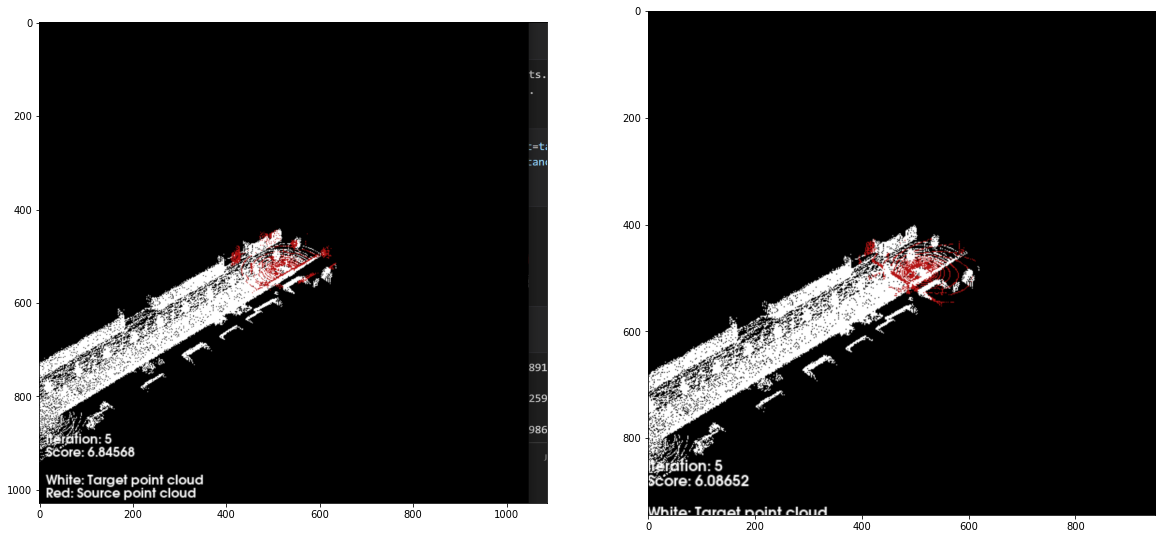

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 20 ,12

# read images
img_A = mpimg.imread('frame100.png')
img_B = mpimg.imread('frame400.png')


# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

##alignment images of frame 100 and frame 400 in the mapcloud



## Runtime

ICP is much faster than NDT takes about 167 seconds for allignment of all 1013 frames with 60 max iterations whereas NDT with 10 max iterations takes about 167 seconds for 10 frames
 

In [8]:
error_icp = np.array(icp_errors)
Mean_icp_error = np.mean(error_icp)
Max_icp_error = np.max(error_icp)

print("Number of sucessful frames localization using ICP :", len(error_icp[error_icp<1.2]))
print("Mean error using ICP localization :",f'{Mean_icp_error:.3f}')
print("Max error using ICP localization :", f'{Max_icp_error:.3f}')
print("Time needed for localization of all frames using ICP :", f'{total_icp_time:.3f}', "seconds")


Number of sucessful frames localization using ICP : 28
Mean error using ICP localization : 94.946
Max error using ICP localization : 182.749
Time needed for localization of all frames using ICP : 167.016 seconds


In [ ]:
error_ndt = np.array(ndt_errors)
Mean_ndt_error = np.mean(error_ndt)
Max_ndt_error = np.max(error_ndt)

print("Number of failed frames localization using NDT :", len(error_ndt[error_ndt<1.2]))
print("Mean error using NDT localization :", f'{Mean_ndt_error:.3f}')
print("Max error using NDT localization :", f'{Max_ndt_error:.3f}')
print("Time needed for localization of all frames using ndt :", f'{total_ndt_time:.3f}', "seconds")